# Pneumonia Classification


* Original image shape 1024x1024 -> 224x224
* Standardize to [0,1] (1/255)
* 24000 to training and 2684 to validation
* 0 if no pneumonia 1 if pneumonia

In [2]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import os

%matplotlib inline

In [3]:
#Reading the csv file

#MODIFICAR RUTA, NO CONFUNDIR TRABAJO LOCAL VS COLAB
labels = pd.read_csv('stage_2_train_labels.csv')

In [4]:
labels.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [5]:
# Remove duplicate
labels = labels.drop_duplicates("patientId")
labels.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


Dicom file paths and npy files

In [6]:
train_images_path = Path('stage_2_train_images')
save_path = Path('Processed')

In [7]:
#Verificamos que toda imagen de entrenamiento tiene anotacion
import glob
patient_ids = labels['patientId'].to_numpy()
train_ids =  glob.glob(os.path.join("stage_2_train_images", '*.dcm'))
ids = []
for i in train_ids:
  ids.append(i.split('/')[-1][:-4])

ids_array = np.array(ids)

patient_ids = set(patient_ids)
ids_array = set(ids_array)

inter = list(patient_ids.intersection(ids_array))
len(inter)

11119

Example images

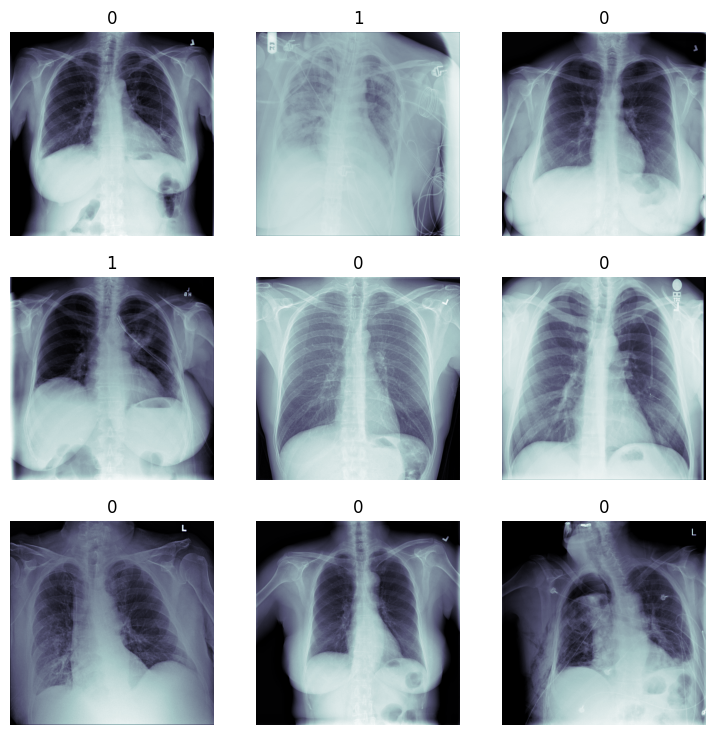

In [8]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))
dcm_paths = train_ids[45:55]
c = 0
for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = train_images_path/patient_id
        dcm_path = dcm_path.with_suffix(".dcm")
        dcm = pydicom.read_file(dcm_paths[c]).pixel_array

        label = labels.loc[labels['patientId'] == dcm_paths[c].split('/')[-1][:-4], 'Target'].values[0]

        axis[i][j].imshow(dcm, cmap="bone")
        axis[i][j].set_title(label)
        axis[i][j].set_axis_off()
        c+=1

## Dicom Reading & Effective storage

In order to efficiently handle our data in the Dataloader, we convert the X-Ray images stored in the DICOM format to numpy arrays. Afterwards we compute the overall mean and standard deviation of the pixels of the whole dataset, for the purpose of normalization.
Then the created numpy images are stored in two separate folders according to their binary label:
* 0: All X-Rays which do not show signs of pneumonia
* 1: All X-Rays which show signs of pneumonia

To do so, we iterate over the patient ids and concat the patient ID with the ROOT_PATH.

We then directly save the standardized and resized files into the corresponding directory (0 for healthy, 1 for pneumonia).
This allows to take advantage of the ready-to-use torchvision **DatasetFolder** for simple file reading


We standardize all images by the maximum pixel value in the provided dataset, 255.
All images are resized to 224x224.

To compute dataset mean and standard deviation, we compute the sum of the pixel values as well as the sum of the squared pixel values for each subject.
This allows to compute the overall mean and standard deviation without keeping the whole dataset in memory.

In [ ]:
sums, sums_squared = 0, 0

for c, patient_id in enumerate(tqdm(train_ids)):
    dcm_path = patient_id

    # Read the dicom file with pydicom and standardize the array
    dcm = pydicom.read_file(dcm_path).pixel_array/255

    # Resize to 224x224 and convert to float16 to reduce the storing space
    dcm_array = cv2.resize(dcm,(224,224)).astype(np.float16)

    # Retrieve the corresponding label
    label = labels.loc[labels['patientId'] == dcm_path.split('\\')[-1][:-4], 'Target'].values[0]

    # Train (4/5) or validate (1/5)
    train_or_val = 'train' if c <8900 else 'val'

    current_save_path = save_path/train_or_val/str(label) # Define save path and create if necessary
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id.split('\\')[-1][:-4], dcm_array)     # Save the array in the corresponding directory

    normalizer = dcm_array.shape[0]*dcm_array.shape[1]
    if train_or_val == 'train':
        sums += np.sum(dcm_array)/normalizer
        sums_squared += (np.power(dcm_array, 2).sum())/normalizer

  0%|          | 0/26684 [00:00<?, ?it/s]

In [ ]:
mean = sums/8900
std = np.sqrt((sums_squared/8900)-mean**2)

In [ ]:
mean, std

(0.4903962485384803, 0.24795070634161256)

## Train 01 - Data Loading

In [1]:
%pip install pytorch_lightning

INFO: pip is looking at multiple versions of pytorch-lightning to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of pytorch-lightning to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 36.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.6/718.6 kB 43.1 MB/s eta 0:00:00
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.4/716.4 kB 40.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 715.6/715.6 kB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 829.5/829.5 kB 51.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [9]:
import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

First we create our dataset.
We can leverage the **DatasetFolder** from torchvision: It allows to simply pass a root directory and return return a dataset object with access to all files within the directory and the directory name as class label. <br />
We only need to define a loader function, **load_file**, which defines how the files shall be loaded.
This is very comfortable as we only have to load our previously stored numpy files.
Additionally, we need to define a list of file extensions (just "npy" in our case).

Finally we can pass a transformation sequence for Data Augmentation and Normalization.

We use:
* RandomResizedCrops which applies a random crop of the image and resizes it to the original image size (224x224)
* Random Rotations between -5 and 5 degrees
* Random Translation (max 5%)
* Random Scaling (0.9-1.1 of original image size)

In [10]:
def load_file(path):
    return np.load(path).astype(np.float32)

In [11]:
s_mean, s_std = 0.49, 0.248

train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(s_mean, s_std),  # Use mean and std from preprocessing notebook
                                    transforms.RandomAffine( # Data Augmentation
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))

])

val_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize([s_mean], [s_std]),  # Use mean and std from preprocessing notebook
])


In [12]:
train_dataset = torchvision.datasets.DatasetFolder(
    os.path.join("Processed", "train"),
    loader=load_file, extensions="npy", transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    os.path.join("Processed", "val"),
    loader=load_file, extensions="npy", transform=val_transforms)

In [13]:
batch_size = 64#TODO
num_workers = 2# TODO

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 8900 train images and 2219 val images


In [14]:
#How many samples we have from each class?
np.unique(train_dataset.targets, return_counts = True)

(array([0, 1]), array([7371, 1529]))

## Train 02 - Model Creation

In [15]:
'''
Modificar capas de entrada (conv1) y de salida (fc) para ajustar a los datos
que serán ingresados al modelo
'''
torchvision.models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self, weight=1):
        super().__init__()

        self.model = torchvision.models.resnet18()
        # change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))

        # simple accuracy computation
        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")

    def forward(self, data):
        pred = self.model(data)
        return pred

    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)[:,0]  # Prediction: Make sure prediction and label have same shape
        loss = self.loss_fn(pred, label)  # Compute the loss

        # Log loss and batch accuracy
        self.log("Train Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
        return loss


    def on_training_epoch_end(self, outs):
      # Use this hook to perform any necessary actions at the end of each training epoch.
      # You can access the outputs from the training step by using the `self.trainer` attribute.
      # For example, to access the losses from each training step:
        train_losses = [x['loss'] for x in self.trainer.logged_metrics]
        avg_train_loss = torch.stack(train_losses).mean()
        self.log('train_loss', avg_train_loss)


    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]  # make sure prediction and label have same shape

        loss = self.loss_fn(pred, label)

        # Log validation metrics
        self.log("Val Loss", loss)
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
        return loss

    def on_validation_epoch_end(self):
        self.log("Val Acc", self.val_acc.compute())

    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]

In [27]:
model = PneumoniaModel()

In [28]:
# Create the checkpoint callback
checkpoint_callback = ModelCheckpoint(
    monitor='Val Acc',
    save_top_k=10,
    mode='max')

Trainer documentation: https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html

In [29]:
# Create the trainer
# Change the gpus parameter to the number of available gpus on your system. Use 0 for CPU training

gpus = 1 #TODO
trainer = pl.Trainer(callbacks=checkpoint_callback,
                     max_epochs=20)

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [30]:
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | BinaryAccuracy    | 0     
3 | val_acc   | BinaryAccuracy    | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Epoch 0:   0%|          | 0/140 [00:00<?, ?it/s]                           

/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to Tr

Epoch 1:   0%|          | 0/140 [00:00<?, ?it/s, v_num=1]          

/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to Tr

Epoch 2:   0%|          | 0/140 [00:00<?, ?it/s, v_num=1]          

/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to Tr

Epoch 3:   0%|          | 0/140 [00:00<?, ?it/s, v_num=1]          

/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to Tr

Epoch 4:   0%|          | 0/140 [00:00<?, ?it/s, v_num=1]          

/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to Tr

Epoch 5:   0%|          | 0/140 [00:00<?, ?it/s, v_num=1]          

/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to Tr

Epoch 6:   0%|          | 0/140 [00:00<?, ?it/s, v_num=1]          

/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to Tr

Epoch 7:   0%|          | 0/140 [00:00<?, ?it/s, v_num=1]          

/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to Tr

Epoch 8:   0%|          | 0/140 [00:00<?, ?it/s, v_num=1]          

/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to Tr

Epoch 9:   0%|          | 0/140 [00:00<?, ?it/s, v_num=1]          

/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to Tr

Epoch 10:   0%|          | 0/140 [00:00<?, ?it/s, v_num=1]         

/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to Tr

Epoch 11:   0%|          | 0/140 [00:00<?, ?it/s, v_num=1]          

/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to Tr

Epoch 12:   0%|          | 0/140 [00:00<?, ?it/s, v_num=1]          

/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to Tr

Epoch 13:   0%|          | 0/140 [00:00<?, ?it/s, v_num=1]          

/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to Tr

Epoch 14:   0%|          | 0/140 [00:00<?, ?it/s, v_num=1]          

/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to Tr

Epoch 15:   0%|          | 0/140 [00:00<?, ?it/s, v_num=1]          

/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to Tr

Epoch 16:   0%|          | 0/140 [00:00<?, ?it/s, v_num=1]          

/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to Tr

Epoch 17:   0%|          | 0/140 [00:00<?, ?it/s, v_num=1]          

/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to Tr

Epoch 18:   0%|          | 0/140 [00:00<?, ?it/s, v_num=1]          

/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to Tr

Epoch 19:   0%|          | 0/140 [00:00<?, ?it/s, v_num=1]          

/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/dlmanrique/anaconda3/envs/st/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to Tr

Epoch 19: 100%|██████████| 140/140 [00:16<00:00,  8.66it/s, v_num=1]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 140/140 [00:16<00:00,  8.48it/s, v_num=1]
